In [3]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import dlc_practical_prologue as prologue
%matplotlib inline
N=1000
from torch.utils.data import DataLoader, Dataset
import tqdm
from torch.autograd import Variable

In [4]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [5]:
class CompareNet(nn.Module):
    def __init__(self):
        super(CompareNet, self).__init__()
        self.base = nn.Sequential(nn.Linear(196,64),nn.ReLU(),nn.Linear(64,32))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(32,10)
    
    def forward(self, x):
        x_0 = x[:,0,:,:].flatten(1)
        x_1 = x[:,1,:,:].flatten(1)
        x_0 = F.relu(self.base(x_0))
        x_1 = F.relu(self.base(x_1))
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        digit_0 = F.relu(self.classifier(x_0))
        digit_1 = F.relu(self.classifier(x_1))
        return sign, digit_0, digit_1
    

In [6]:
class DigitPairsDataset(Dataset):
    def __init__(self,img_pair,targets, classes):
        super(DigitPairsDataset, self).__init__()
        self.img_pair = img_pair
        self.targets = targets
        self.classes = classes
    
    def __len__(self):
        return self.targets.size()[0]
    
    def __getitem__(self, idx):
        return self.img_pair[idx], self.targets[idx], self.classes[idx]

In [7]:
net = CompareNet()
criterion = nn.CrossEntropyLoss()
mu = 1.0
optimizer = optim.Adam(net.parameters(),lr = 0.001)
train_dataset = DigitPairsDataset(train_input,train_target,train_classes)
test_dataset = DigitPairsDataset(test_input,test_target,test_classes)
train_loader = DataLoader(train_dataset,batch_size=32, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle = True, num_workers = 4)

def calc_accuracy(data_loader,model):
    correct_count = 0.0
    for i, data in enumerate(data_loader,0):
        img_pair, target, classes = data
        pred_sign, pred_class0, pred_class1 = model(img_pair)
        pred = torch.argmax(pred_sign,-1)
        correct_count += int((target.eq(pred)).sum())
    return correct_count*100.0/N

epochs = 200
loss_arr = []
train_acc_arr = []
val_acc_arr = []

for epoch in tqdm.tqdm(range(epochs)):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        img_pair, target, classes = data
        optimizer.zero_grad()

        pred_sign, pred_class0, pred_class1 = net(img_pair)
        loss = criterion(pred_sign,target)+ mu*(criterion(pred_class0, classes[:,0])+ criterion(pred_class1, classes[:,1]))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    net.eval()
    running_loss /= N
    loss_arr.append(running_loss)
    train_acc = calc_accuracy(train_loader,net)
    val_acc = calc_accuracy(test_loader,net)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)
    if epoch % 10 == 9:
        print("Epoch : %d  ,   Train Accuracy : %.2f  , Validation Accuracy : %.2f , Training Loss : %.6f" %(epoch, train_acc, val_acc, running_loss))

  5%|▌         | 10/200 [00:05<01:41,  1.87it/s]

Epoch : 9  ,   Train Accuracy : 76.90  , Validation Accuracy : 70.60 , Training Loss : 0.050010


 10%|█         | 20/200 [00:11<01:31,  1.96it/s]

Epoch : 19  ,   Train Accuracy : 92.80  , Validation Accuracy : 81.70 , Training Loss : 0.023110


 15%|█▌        | 30/200 [00:15<01:21,  2.09it/s]

Epoch : 29  ,   Train Accuracy : 97.00  , Validation Accuracy : 84.60 , Training Loss : 0.018908


 20%|██        | 40/200 [00:20<01:19,  2.02it/s]

Epoch : 39  ,   Train Accuracy : 98.10  , Validation Accuracy : 83.80 , Training Loss : 0.017665


 25%|██▌       | 50/200 [00:25<01:16,  1.95it/s]

Epoch : 49  ,   Train Accuracy : 98.40  , Validation Accuracy : 84.20 , Training Loss : 0.017906


 30%|███       | 60/200 [00:31<01:12,  1.93it/s]

Epoch : 59  ,   Train Accuracy : 93.50  , Validation Accuracy : 83.00 , Training Loss : 0.027013


 35%|███▌      | 70/200 [00:36<01:04,  2.01it/s]

Epoch : 69  ,   Train Accuracy : 99.00  , Validation Accuracy : 85.60 , Training Loss : 0.016722


 40%|████      | 80/200 [00:41<01:00,  1.97it/s]

Epoch : 79  ,   Train Accuracy : 99.00  , Validation Accuracy : 85.40 , Training Loss : 0.016868


 45%|████▌     | 90/200 [00:46<00:59,  1.86it/s]

Epoch : 89  ,   Train Accuracy : 97.90  , Validation Accuracy : 84.60 , Training Loss : 0.017759


 50%|█████     | 100/200 [00:51<00:48,  2.07it/s]

Epoch : 99  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.10 , Training Loss : 0.016578


 55%|█████▌    | 110/200 [00:56<00:52,  1.72it/s]

Epoch : 109  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.30 , Training Loss : 0.016691


 60%|██████    | 120/200 [01:04<00:58,  1.36it/s]

Epoch : 119  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.10 , Training Loss : 0.016232


 65%|██████▌   | 130/200 [01:10<00:36,  1.93it/s]

Epoch : 129  ,   Train Accuracy : 99.70  , Validation Accuracy : 85.90 , Training Loss : 0.016444


 70%|███████   | 140/200 [01:16<00:33,  1.78it/s]

Epoch : 139  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.40 , Training Loss : 0.016011


 75%|███████▌  | 150/200 [01:22<00:33,  1.50it/s]

Epoch : 149  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.30 , Training Loss : 0.016656


 80%|████████  | 160/200 [01:29<00:23,  1.69it/s]

Epoch : 159  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.60 , Training Loss : 0.016224


 85%|████████▌ | 170/200 [01:38<00:23,  1.30it/s]

Epoch : 169  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.60 , Training Loss : 0.016223


 90%|█████████ | 180/200 [01:44<00:10,  1.82it/s]

Epoch : 179  ,   Train Accuracy : 99.70  , Validation Accuracy : 86.50 , Training Loss : 0.016006


 95%|█████████▌| 190/200 [01:50<00:05,  1.67it/s]

Epoch : 189  ,   Train Accuracy : 97.10  , Validation Accuracy : 85.30 , Training Loss : 0.023632


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]

Epoch : 199  ,   Train Accuracy : 99.50  , Validation Accuracy : 87.00 , Training Loss : 0.016322


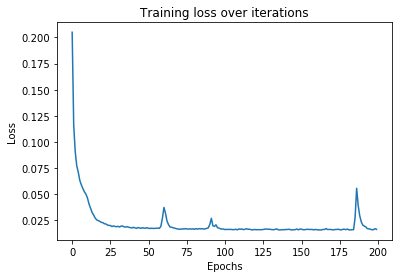

In [7]:
plt.plot(range(epochs),loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss over iterations")
plt.show()

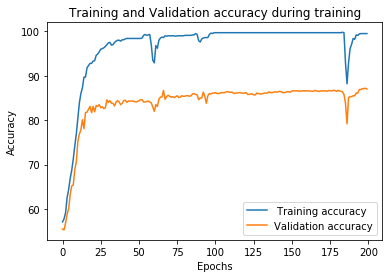

In [8]:
plt.plot(range(epochs),train_acc_arr, label  =" Training accuracy")
plt.plot(range(epochs), val_acc_arr, label ="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Training and Validation accuracy during training")
plt.legend()
plt.show()